In [19]:
import pandas as pd
import re

# --- 1. Читаем файл как одну строку ---
with open('../data/data.csv', 'r', encoding='utf-8') as f:
    raw = f.read().strip()

# --- 2. Вставляем перенос строки перед каждой новой записью ---
# Цена — число, следующая запись — заглавная буква
fixed = re.sub(r'(\d)([A-Z])', r'\1\n\2', raw)

# --- 3. Сохраняем исправленный CSV ---
with open('../data/data_fixed.csv', 'w', encoding='utf-8') as f:
    f.write(fixed)

# --- 4. Загружаем как CSV с 16 колонками ---
columns = [
    'make', 'model', 'year', 'engine_fuel_type', 'engine_hp', 'engine_cylinders',
    'transmission_type', 'driven_wheels', 'number_of_doors', 'market_category',
    'vehicle_size', 'vehicle_style', 'highway_mpg', 'city_mpg', 'popularity', 'msrp'
]

df = pd.read_csv('../data/data_fixed.csv', header=None, names=columns)

# --- 5. Преобразуем msrp в числовой тип ---
df['msrp'] = pd.to_numeric(df['msrp'], errors='coerce')
df = df.dropna(subset=['msrp'])

print("✅ Данные успешно загружены.")
print("Размер датасета:", df.shape)

✅ Данные успешно загружены.
Размер датасета: (11679, 16)


In [20]:
# Преобразуем числовые колонки в числовой тип
numeric_columns = [
    'year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity', 'msrp'
]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Пропуски по колонкам:
make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3691
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64


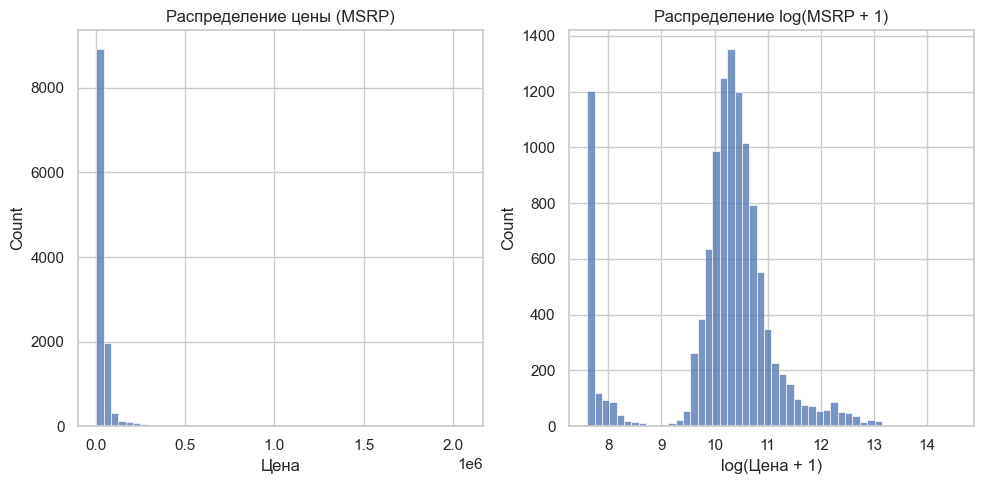


Статистики по цене:
count    1.167900e+04
mean     4.050823e+04
std      6.023319e+04
min      2.000000e+03
25%      2.099500e+04
50%      2.990000e+04
75%      4.229500e+04
max      2.065902e+06
Name: msrp, dtype: float64


In [21]:
# Проверка пропусков
print("Пропуски по колонкам:")
print(df.isnull().sum())

# Распределение целевой переменной (цены)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['msrp'], bins=50, kde=False)
plt.title('Распределение цены (MSRP)')
plt.xlabel('Цена')

# Логарифмическое преобразование для устранения "длинного хвоста"
log_msrp = np.log1p(df['msrp'])
plt.subplot(1, 2, 2)
sns.histplot(log_msrp, bins=50, kde=False)
plt.title('Распределение log(MSRP + 1)')
plt.xlabel('log(Цена + 1)')

plt.tight_layout()
plt.show()

# Основные статистики
print("\nСтатистики по цене:")
print(df['msrp'].describe())

In [22]:
# Преобразуем 'number_of_doors' в числовой тип (остальные числовые колонки уже обработаны ранее)
df['number_of_doors'] = pd.to_numeric(df['number_of_doors'], errors='coerce')

# Теперь можно безопасно заполнять пропуски
df['engine_hp'] = df['engine_hp'].fillna(df['engine_hp'].median())
df['engine_cylinders'] = df['engine_cylinders'].fillna(df['engine_cylinders'].median())
df['number_of_doors'] = df['number_of_doors'].fillna(df['number_of_doors'].median())

# Категориальные — модой
df['engine_fuel_type'] = df['engine_fuel_type'].fillna(df['engine_fuel_type'].mode()[0])
df['market_category'] = df['market_category'].fillna('unknown')

# Проверка
print("Пропуски после обработки:")
print(df.isnull().sum().sum())  # должно быть 0

Пропуски после обработки:
0


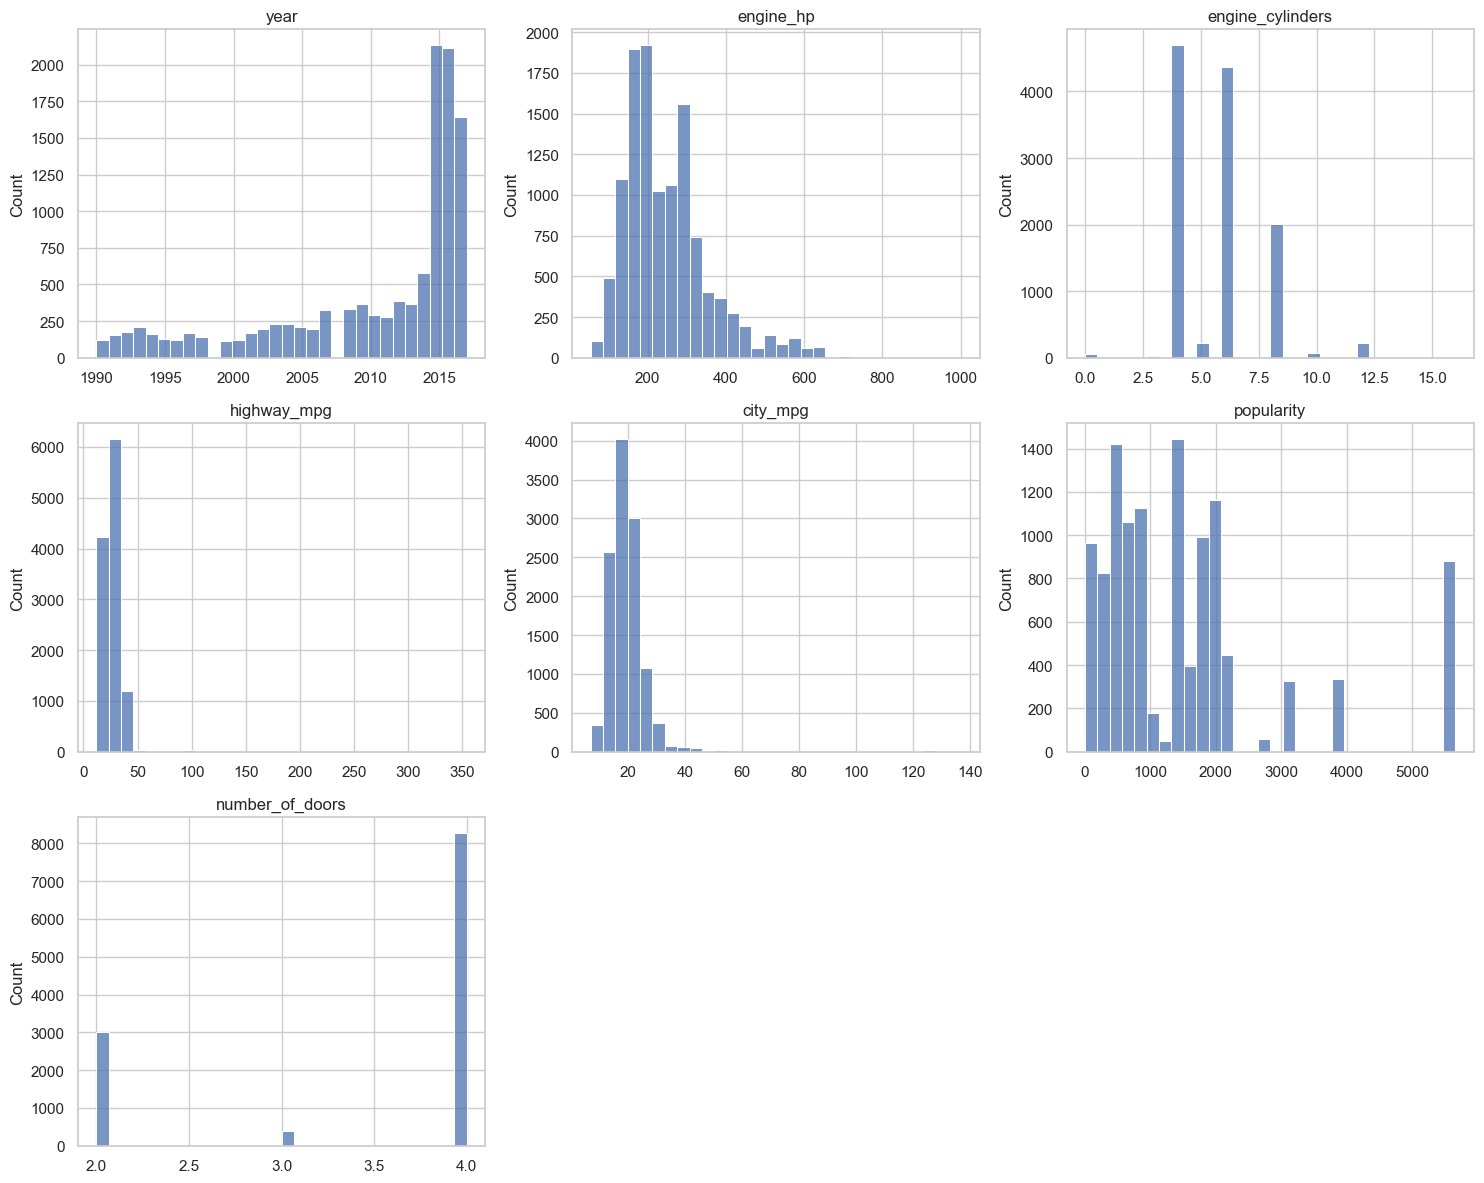

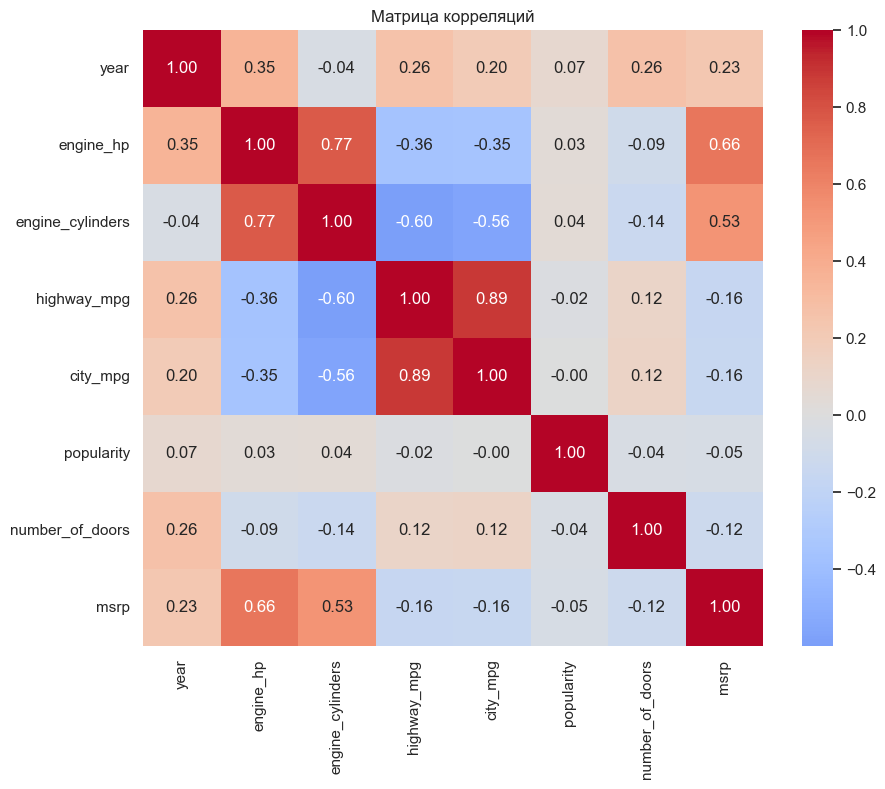

In [23]:
# Числовые признаки (без целевой переменной)
num_features = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity', 'number_of_doors']

# Визуализация распределений
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(num_features):
    sns.histplot(df[col], bins=30, ax=axes[i], kde=False)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')

# Удаляем пустые подграфики
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Матрица корреляций
plt.figure(figsize=(10, 8))
corr = df[num_features + ['msrp']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

C:\Temp\ipykernel_9908\2018551292.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_makes.values, y=top_makes.index, palette='viridis')


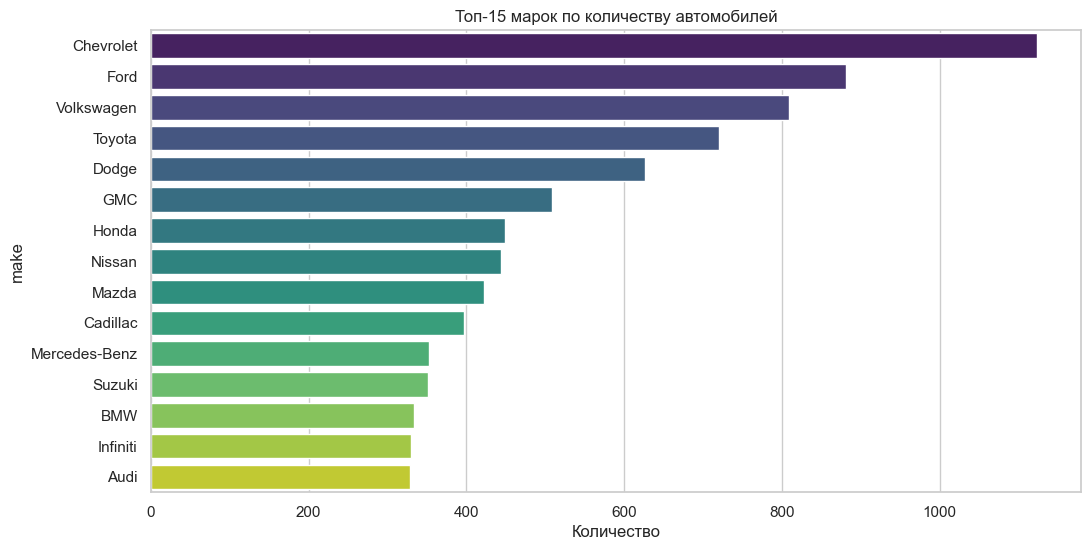

C:\Temp\ipykernel_9908\2018551292.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_make.values, y=avg_price_by_make.index, palette='plasma')


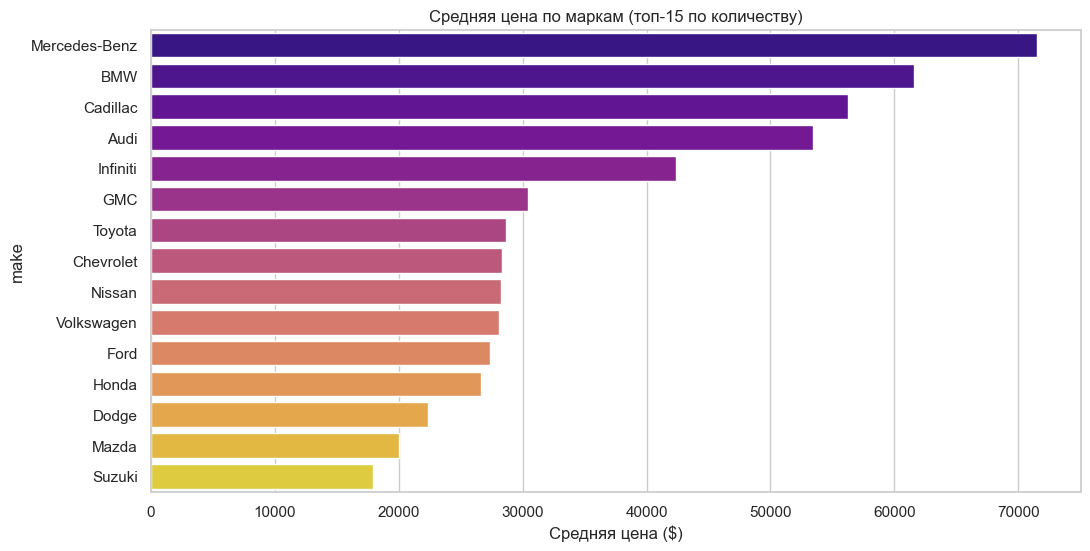

In [24]:
# Категориальные признаки
cat_features = ['make', 'vehicle_size', 'vehicle_style', 'transmission_type', 'driven_wheels']

# Распределение популярных марок
plt.figure(figsize=(12, 6))
top_makes = df['make'].value_counts().head(15)
sns.barplot(x=top_makes.values, y=top_makes.index, palette='viridis')
plt.title('Топ-15 марок по количеству автомобилей')
plt.xlabel('Количество')
plt.show()

# Средняя цена по маркам (топ-15)
plt.figure(figsize=(12, 6))
avg_price_by_make = df.groupby('make')['msrp'].mean().loc[top_makes.index].sort_values(ascending=False)
sns.barplot(x=avg_price_by_make.values, y=avg_price_by_make.index, palette='plasma')
plt.title('Средняя цена по маркам (топ-15 по количеству)')
plt.xlabel('Средняя цена ($)')
plt.show()

In [25]:
# Выводы из EDA
print("✅ Основные выводы:")
print("- Целевая переменная 'msrp' имеет длинный правый хвост → логарифмирование уместно.")
print("- Сильной линейной корреляции с числовыми признаками нет.")
print("- Категориальный признак 'make' оказывает сильное влияние на цену.")
print("- Пропуски обработаны: числовые — медианой, категориальные — модой или 'unknown'.")
print("- Датасет содержит 11 679 записей, все колонки готовы к feature engineering.")

✅ Основные выводы:
- Целевая переменная 'msrp' имеет длинный правый хвост → логарифмирование уместно.
- Сильной линейной корреляции с числовыми признаками нет.
- Категориальный признак 'make' оказывает сильное влияние на цену.
- Пропуски обработаны: числовые — медианой, категориальные — модой или 'unknown'.
- Датасет содержит 11 679 записей, все колонки готовы к feature engineering.
